# CME 241 (Winter 2021) -- Assignment 8

## Question 3

In [1]:
from dataclasses import dataclass
from enum import Enum, auto
import functools
from typing import Callable, Iterable, Iterator, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np

from rl.markov_decision_process import (
    MarkovDecisionProcess as MDP,
    Policy
)
from rl.distribution import (
    Distribution,
    SampledDistribution as Sampler,
    Gaussian,
    Choose
)
from rl.approximate_dynamic_programming import back_opt_vf_and_policy
from rl.function_approx import (
    FunctionApprox as FuncApprox, 
    LinearFunctionApprox
)

In [2]:
@dataclass(frozen=True)
class S:
    """State is solely determined by the underlying price."""
    price: float


class A(Enum):
    """Actions are either hold or exercise."""
    exr = auto()
    hold = auto()


@dataclass(frozen=True)
class AmericanOptionSolver:
    """
    The fundamental functionality of this class is to produce a sequence
    of `MDP_FuncApprox_Distribution` (defined in 
    approcimate_dynamic_programming.py). After initializing a problem
    instance, call AmericanOptionSolver.solve() to compute optimal
    value function and policy.
    """
    
    strike: float
    ir: float
    call: bool
    single_step_dist: Distribution[float]
    initial_state_dist: Distribution[S]
    approximator: FuncApprox[S]
    time_to_expiry: float
    num_steps: int = 50
        
    @property
    def dt(self) -> float:
        """Size of one time step."""
        return self.time_to_expiry / self.num_steps
    
    @property
    def gamma(self) -> float:
        """Compute the discount factor."""
        return np.exp(-self.ir * self.dt)
    
    def get_mdp(self, i: int) -> MDP[S, A]:
        """Construct an MDP for a given time slice."""
        
        # extract attributes so we can access within inner class
        call = self.call
        strike = self.strike
        steps = self.num_steps
        distribution = self.single_step_dist
        
        class AmericanOption(MDP[S, A]):
            """
            An MDP representation of the American Option problem at
            a particular point in time.
            """
            
            def _payoff(self, val: float) -> float:
                """Compute the payoff given an underlying price x."""
                if call:
                    return max(val - strike, 0.)
                return max(strike - val, 0.)
            
            def step(self, state: S, action: A) -> Sampler[Tuple[S, float]]:
                """Step the MDP to the next state with reward."""
                
                def _sample_func() -> Tuple[S, float]:
                    """Define a stochastic step to the next state."""
                    price = state.price + distribution.sample()
                    if i == steps - 1:
                        reward = self._payoff(state.price)
                    else:
                        reward = 0.0
                    return S(price), reward
                
                # Only do 1000 samples for computational tractability
                return Sampler(_sample_func, expectation_samples=1000)
            
            def actions(self, state: S) -> Iterable[A]:
                """Yield possible actions from a state."""
                yield from A
            
        return AmericanOption()
    
    def get_states_distribution(self, i: int) -> Sampler[S]:
        """Generate a distribution of states at a time slice."""
        
        def _sample_func() -> S:
            """Generate a single price path."""
            price: float = self.initial_state_dist.sample().price
            for _ in range(i):
                price += self.single_step_dist.sample()
            return S(price)
        
        return Sampler(_sample_func, expectation_samples=1000)

    def solve(
        self, *, num_samples: int = 500
    ) -> Iterator[Tuple[FuncApprox[S], Policy[S, A]]]:
        """Solve for value function and policy for a chain of MDPs."""
        approximator = self.approximator
        chain: List[Tuple[MDP[S, A], FuncApprox[S], Distribution[S]]] = [
            (self.get_mdp(i), approximator, self.get_states_distribution(i)) 
            for i in range(self.num_steps)
        ]
        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=chain,
            γ=self.gamma,
            num_state_samples=num_samples,
            error_tolerance=1e-4,
        )

In [3]:
@functools.lru_cache
def laguerre(x: float, *, k: int) -> Callable[[float], float]:
    """Compute the kth laguerre polynomial value."""
    if k == 0:
        return 1.
    if k == 1:
        return 1. - x
    a = laguerre(x, k=k - 1) 
    b = laguerre(x, k=k - 2)
    return (2 * k + 1 - x) * a - k * b / (k + 1)

In [4]:
increments = Gaussian(0.5, 1)
initializations = Choose({S(i) for i in range(80, 120)})


f0 = lambda x: laguerre(x.price, k=0)
f1 = lambda x: laguerre(x.price, k=1)
f2 = lambda x: laguerre(x.price, k=2)
f3 = lambda x: laguerre(x.price, k=3)

funcs = [f0, f1, f2, f3]
approx = LinearFunctionApprox[S].create(
    feature_functions=funcs,
    direct_solve=False
)

mdp = AmericanOptionSolver(
    strike=100,
    ir=0.02,
    call=True,
    single_step_dist=increments,
    initial_state_dist=initializations,
    approximator=approx,
    time_to_expiry=1,
)

In [5]:
sols = list(mdp.solve())

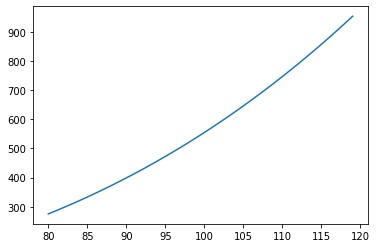

In [6]:
pricer, policy = sols[0]
spots = [S(i) for i in range(80, 120)]
plt.plot([s.price for s in spots], pricer.evaluate(spots))